Project Title:

TCS Stock Price Prediction Using LSTM

Project Description:

This project predicts the future stock prices of TCS (Tata Consultancy Services) using Long Short-Term Memory (LSTM) networks in PyTorch.

The model is trained on historical stock closing prices from 2015 to 2025, and it can forecast stock prices for any number of future days specified by the user. The project also provides a graphical comparison between historical prices and predicted future prices.


Why LSTM?

Stock price prediction is a time series problem, where past trends influence future prices.

LSTM is a type of Recurrent Neural Network (RNN) specially designed to handle long-term dependencies in sequential data.

Vanilla RNNs often suffer from the vanishing gradient problem, which makes them struggle to learn patterns from long sequences (like 60+ days of stock prices).

LSTM solves this problem with memory cells and gates (input, forget, output), allowing the network to remember relevant information over long periods.

Therefore, LSTM is better suited than a basic RNN for stock price forecasting.

In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.metrics import r2_score


In [15]:
df = yf.download("TCS.NS", start="2015-01-01", end="2025-01-01")
data = df[['Close']].values


/tmp/ipython-input-1306015202.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("TCS.NS", start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


In [16]:
data

array([[1073.51000977],
       [1087.8067627 ],
       [1071.27490234],
       ...,
       [4104.4140625 ],
       [4098.45166016],
       [4035.38085938]])

In [17]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)


Scales the stock prices to [0,1] using MinMaxScaler.

Neural networks perform better on normalized data.

Later, predictions are inversed to original scale for interpretation.

In [33]:
scaled_data


array([[0.04413903],
       [0.04815453],
       [0.04351126],
       ...,
       [0.8954229 ],
       [0.89374825],
       [0.87603368]])

In [18]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i+seq_length)]  # past 60 days
        y = data[i+seq_length]      # next day
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LEN = 60
X, y = create_sequences(scaled_data, SEQ_LEN)


Converts the 1D stock price series into input-output pairs.

Uses SEQ_LEN = 60, i.e., past 60 days are used to predict the next day.

Outputs:

X → sequences of 60 days each

y → the corresponding next day price

In [19]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


Convert NumPy arrays to PyTorch tensors

X_train, y_train, X_test, y_test were initially NumPy arrays generated from the historical stock prices.

PyTorch’s neural network layers, including nn.LSTM, require inputs in tensor format.

Set data type to float32

Neural networks perform numerical computations with floating-point numbers.

Using dtype=torch.float32 ensures compatibility and efficient computation on both CPU and GPU.

Shape of the data for LSTM

X_train → (num_train_samples, seq_len, num_features)

num_train_samples = number of training sequences (80% of total sequences)

seq_len = length of each input sequence (e.g., 60 past days)

num_features = 1 (closing price)

y_train → (num_train_samples, 1)

Each target is the next day’s stock price corresponding to the input sequence

Why separate train and test sets?

X_train / y_train → used to train the model

X_test / y_test → used to evaluate model performance and validate predictions

In [20]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=64, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # last time step output
        return out


Defines a custom LSTM model:

input_size=1 → one feature (closing price) per time step

hidden_layer_size=64 → LSTM memory units

output_size=1 → predict one price

forward method:

Passes input through LSTM layer

Takes last time step hidden state

Passes it through fully connected layer to get prediction

In [22]:
model = LSTM()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [23]:
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = loss_fn(outputs, y_train)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        train_pred = outputs.detach().numpy()
        train_true = y_train.detach().numpy()
        r2 = r2_score(train_true, train_pred)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.6f}, R² Score: {r2:.4f}")

Epoch 10/50, Loss: 0.058701, R² Score: -0.0172
Epoch 20/50, Loss: 0.049429, R² Score: 0.1435
Epoch 30/50, Loss: 0.036738, R² Score: 0.3634
Epoch 40/50, Loss: 0.018602, R² Score: 0.6777
Epoch 50/50, Loss: 0.005728, R² Score: 0.9007


Uses Mean Squared Error (MSE) loss function.

Optimizes weights using Adam optimizer.

For each epoch:

Computes predictions

Calculates loss

Performs backpropagation

Updates model parameters

In [24]:
model.eval()
train_pred = model(X_train).detach().numpy()
test_pred = model(X_test).detach().numpy()


In [25]:
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
y_train_real = scaler.inverse_transform(y_train.detach().numpy())
y_test_real = scaler.inverse_transform(y_test.detach().numpy())


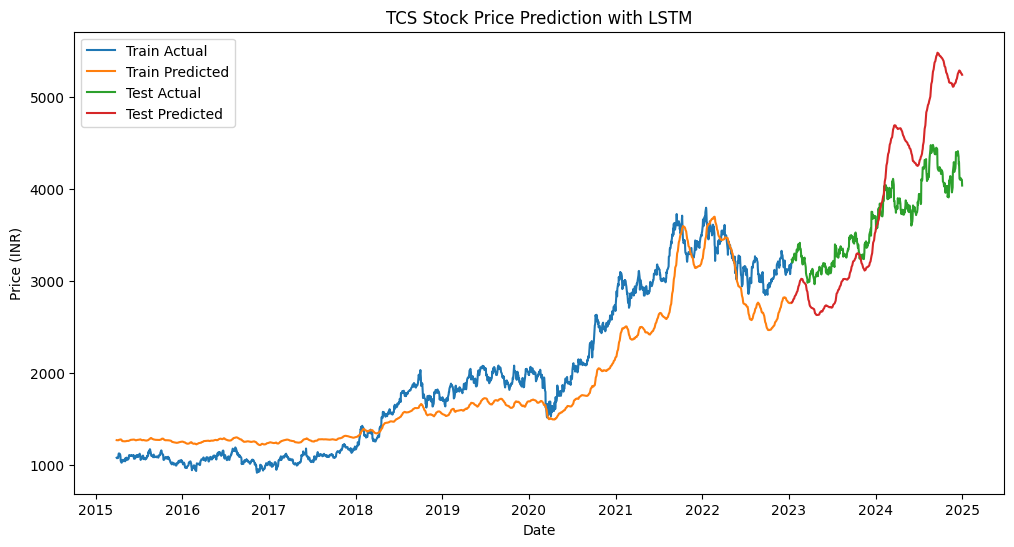

In [26]:
plt.figure(figsize=(12,6))
plt.plot(df.index[SEQ_LEN:train_size+SEQ_LEN], y_train_real, label="Train Actual")
plt.plot(df.index[SEQ_LEN:train_size+SEQ_LEN], train_pred, label="Train Predicted")
plt.plot(df.index[train_size+SEQ_LEN:], y_test_real, label="Test Actual")
plt.plot(df.index[train_size+SEQ_LEN:], test_pred, label="Test Predicted")
plt.title("TCS Stock Price Prediction with LSTM")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.show()


In [27]:
torch.save(model.state_dict(), "tata_lstm_model.pth")
print("✅ Model saved as tata_lstm_model.pth")

✅ Model saved as tata_lstm_model.pth


In [28]:
loaded_model = LSTM()
loaded_model.load_state_dict(torch.load("tata_lstm_model.pth"))
loaded_model.eval()
print("✅ Model loaded for prediction")

✅ Model loaded for prediction


In [29]:
def predict_future(model, data, future_days=7):
    last_seq = data[-SEQ_LEN:]  # last 60 days
    predictions = []
    seq = torch.tensor(last_seq.reshape(1, SEQ_LEN, 1), dtype=torch.float32)

    for _ in range(future_days):
        with torch.no_grad():
            pred = model(seq).item()
        predictions.append(pred)

        # update sequence: drop first day, add predicted day
        new_seq = seq.numpy().flatten().tolist()[1:] + [pred]
        seq = torch.tensor(np.array(new_seq).reshape(1, SEQ_LEN, 1), dtype=torch.float32)

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions

Uses the last 60 days as input.

Iteratively predicts the next day, adds it to the sequence, and predicts again.

Converts predictions back to original stock price scale.

In [30]:
future_days = 10   # 🔹 change this value (e.g., 7, 15, 30)
future_predictions = predict_future(loaded_model, scaled_data, future_days)

print(f"\n📈 Predicted stock prices for next {future_days} days:")
print(future_predictions)



📈 Predicted stock prices for next 10 days:
[[5227.66820173]
 [5304.08841484]
 [5384.4520235 ]
 [5468.15930562]
 [5553.27697452]
 [5638.33394967]
 [5722.42237152]
 [5804.59066406]
 [5884.29767678]
 [5961.09011654]]


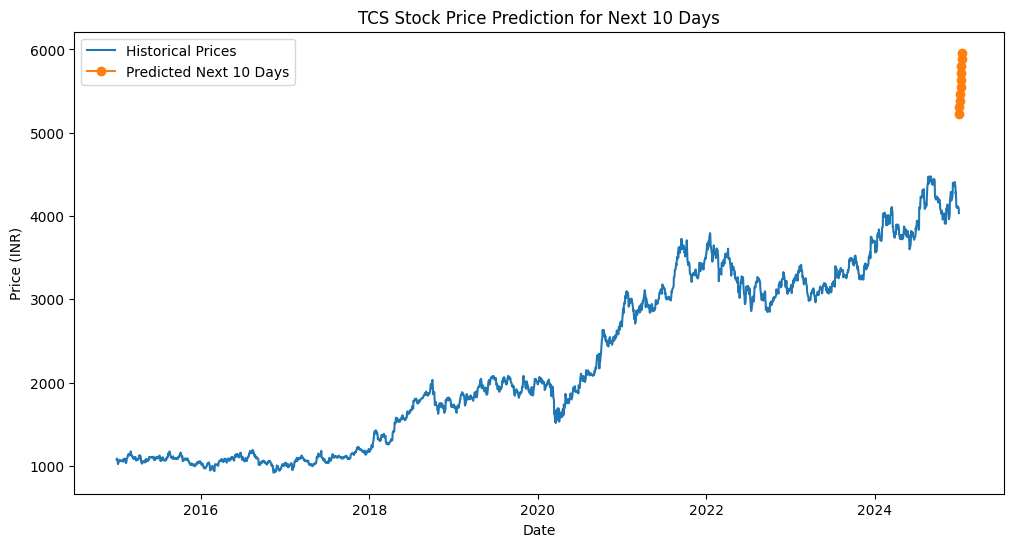

In [32]:
plt.figure(figsize=(12,6))
plt.plot(df.index, data, label="Historical Prices")

# Future prediction dates
future_dates = pd.date_range(start=df.index[-1], periods=future_days+1, freq='B')[1:]
plt.plot(future_dates, future_predictions, label=f"Predicted Next {future_days} Days", marker="o")

plt.title(f"TCS Stock Price Prediction for Next {future_days} Days")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.show()